In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/msambare/fer2013")

In [ ]:
img_array = cv2.imread("/content/fer2013/train/1/Training_10371709.jpg")
img_array.shape

Hense image is RGB image due to the three channels

In [ ]:
plt.imshow(img_array)  #BGR

In [ ]:
train_data_dir ='/content/fer2013/train'
test_data_dir ='/content/fer2013/test'

In [1]:
batch_size = 64
image_size =(224,224)

In [ ]:
training_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                            batch_size=batch_size,
                                                            image_size=image_size,
                                                            shuffle=True,
                                                            seed= 123,
                                                            label_mode='int'
                                                            )


testing_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                            batch_size=batch_size,
                                                            image_size=image_size,
                                                            shuffle=True,
                                                            seed= 123,
                                                            label_mode='int',
                                                            )


Clsses of the trainning data

In [ ]:
training_data.class_names

Classes of the testing data

In [ ]:
testing_data.class_names

In [ ]:
# Determine the number of batches
num_batches = tf.data.experimental.cardinality(training_data).numpy()
print(f"Number of batches: {num_batches}")

# Determine the total number of samples
num_samples = num_batches * batch_size
print(f"Number of samples: {num_samples}")

### Training data set

In [ ]:
for image_batch,label_batch in training_data.take(1):
  print(image_batch)
  print(label_batch)

### Testing data set

In [ ]:
for image_batch,label_batch in testing_data.take(1):
  print(image_batch)
  print(label_batch)

In [ ]:
for image_batch,label_batch in training_data.take(1):
  print(image_batch.shape)  # batch details
  print(label_batch.shape)  # no of labels in a batch

Normalizing data

In [ ]:
train_data = training_data.map(lambda x,y:(x/255,y))
test_data = testing_data.map(lambda x,y:(x/255,y))

In [ ]:
for image_batch,label_batch in train_data.take(1):
  print(image_batch)


### Transfer Learning

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = tf.keras.applications.MobileNetV2()   # Pre- trained model

In [ ]:
model.summary()

Model Tuning

In [ ]:
base_input = model.layers[1].input
base_input

In [ ]:
base_output = model.layers[-2].output
base_output

In [ ]:
final_output = keras.layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = keras.layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = keras.layers.Dense(7,activation='softmax')(final_output)

In [ ]:
final_output


In [ ]:
new_model = keras.Model(inputs=base_input,outputs= final_output)

## Compile model

In [ ]:
new_model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

## Model training

In [ ]:
history=new_model.fit(train_data,epochs=25)

In [ ]:
plt.plot(history.history['accuracy'],label="accuracy")
plt.legend()
plt.title('model accuracy')
plt.xlabel('epoch')
plt.show()


In [ ]:
plt.plot(history.history['loss'],label="loss")
plt.legend()
plt.title('model Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
new_model.save("face_emotion.h5")

In [3]:
final_model = tf.keras.models.load_model("./face_emotion.h5")

In [73]:
img = cv2.imread("test/0/PublicTest_44022516.jpg")
img.shape


(48, 48, 3)

In [74]:
resized_image = tf.image.resize(img, image_size)
scaled_image = resized_image/255

NameError: name 'image_size' is not defined

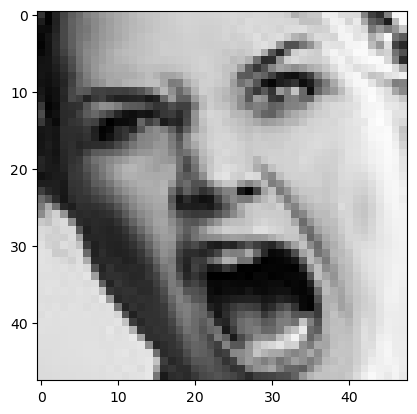

In [75]:
plt.imshow(img)

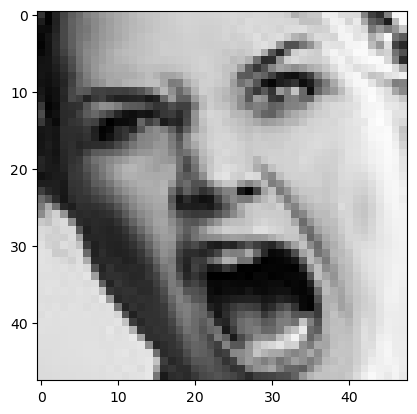

In [76]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [77]:
np.expand_dims(scaled_image, 0).shape

NameError: name 'scaled_image' is not defined

In [78]:
prediction=final_model.predict(np.expand_dims(scaled_image, 0))
prediction

NameError: name 'final_model' is not defined

In [79]:
label = np.argmax(prediction)

if label == 0:
  print("Angry")
elif label == 1:
  print("Disgust")
elif label ==2:
  print("Fear")
elif label ==3:
  print("Happy")
elif label ==4:
  print("Neutral")
elif label ==5:
  print("Sad")
elif label ==6:
  print("Suprise")

NameError: name 'prediction' is not defined

We Need Faced Detection Algorithm (gray images)

In [80]:
# Load OpenCV's pre-trained Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [81]:
def preprocess_face(face_img):
    # Resize the face image to the input size of your model
    face_img = cv2.resize(face_img, (224, 224))
    face_img = face_img / 255.0  # Normalize the image
    face_img = np.expand_dims(face_img, axis=0)  # Add batch dimension
    return face_img


In [82]:
def recognize_face(face_img):
    preprocessed_face = preprocess_face(face_img)
    prediction = final_model.predict(preprocessed_face)
    label = np.argmax(prediction, axis=1)[0]

    # Map the label to the corresponding emotion
    emotions = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
    recognized_emotion = emotions[label]
    return recognized_emotion



In [83]:
def start_face_recognition_demo():
    cap = cv2.VideoCapture(0)  # Open the default camera

    while True:
        ret, frame = cap.read()  # Capture frame-by-frame
        if not ret:
            break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        for (x, y, w, h) in faces:
            face_img = frame[y:y+h, x:x+w]
            recognized_person = recognize_face(face_img)

            # Draw a rectangle around the face
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
            # Display the recognized person's ID
            cv2.putText(frame, str(recognized_person), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

        cv2.imshow('Face Recognition', frame)  # Display the resulting frame

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

start_face_recognition_demo()



NameError: name 'final_model' is not defined

: 

### Step 1: Import necessary libraries

In [19]:
import cv2
import numpy as np
import tensorflow as tf
from mtcnn.mtcnn import MTCNN
from fer import FER
import matplotlib.pyplot as plt

# Initialize MTCNN face detector
detector = MTCNN()

# Initialize FER emotion detector
emotion_detector = FER()

# Load your pre-trained deep learning model for face recognition
model = tf.keras.models.load_model('./face_emotion.h5')


### Step 2: Define functions for preprocessing, recognition, and displaying results

In [58]:
def preprocess_face(face_img):
    face_img = cv2.resize(face_img, (224, 224))
    face_img = face_img / 255.0
    face_img = np.expand_dims(face_img, axis=0)
    return face_img

def recognize_face(face_img):
    preprocessed_face = preprocess_face(face_img)
    prediction = model.predict(preprocessed_face)
    recognized_person = np.argmax(prediction, axis=1)[0]
    return recognized_person

def map_emotion_label(label):
    if label == 0:
        return "Angry"
    elif label == 1:
        return "Disgust"
    elif label == 2:
        return "Fear"
    elif label == 3:
        return "Happy"
    elif label == 4:
        return "Neutral"
    elif label == 5:
        return "Sad"
    elif label == 6:
        return "Surprise"
    return "Unknown"

def display_results(image, faces, recognized_persons, emotions):
    for (box, person_id, emotion_label) in zip(faces, recognized_persons, emotions):
        x, y, w, h = box
        # cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        # cv2.putText(image, f'ID: {person_id}', (x, y-30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
        emotion=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
        # cv2.putText(image, f'Emotion: {emotion[person_id]}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    print(emotion[person_id])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


### Step 3: Function to process an image

In [59]:
def process_image(image_path):
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(rgb_image)
    
    recognized_persons = []
    emotions = []

    for detection in faces:
        x, y, w, h = detection['box']
        face_img = image[y:y+h, x:x+w]

        recognized_person = recognize_face(face_img)
        recognized_persons.append(recognized_person)

        emotion = emotion_detector.detect_emotions(face_img)
        if emotion:
            emotion_label = max(emotion[0]['emotions'], key=emotion[0]['emotions'].get)
            emotion_label_index = list(emotion[0]['emotions'].keys()).index(emotion_label)
            emotion_label = map_emotion_label(emotion_label_index)
        else:
            emotion_label = 'None'
        emotions.append(emotion_label)

    display_results(image, [d['box'] for d in faces], recognized_persons, emotions)
 


### Step 4: Run the function with an image

1/1 [==============================] - 0s 82ms/step
Surprise


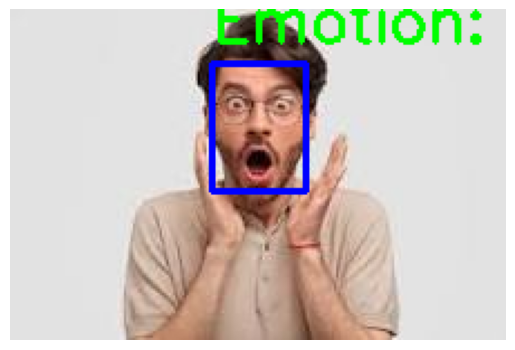

In [63]:
image_path = 'download.jpeg'  # Replace with your image path
process_image(image_path)
